Epoch 1/15, Train Loss: 1.2761, Val Loss: 0.9859
Epoch 2/15, Train Loss: 0.8674, Val Loss: 0.8116
Epoch 3/15, Train Loss: 0.6981, Val Loss: 0.8081
Epoch 4/15, Train Loss: 0.5783, Val Loss: 0.7332
Epoch 5/15, Train Loss: 0.4896, Val Loss: 0.7587
Epoch 6/15, Train Loss: 0.3949, Val Loss: 0.6058
Epoch 7/15, Train Loss: 0.3238, Val Loss: 0.6661
Epoch 8/15, Train Loss: 0.2538, Val Loss: 0.8447
Epoch 9/15, Train Loss: 0.2056, Val Loss: 0.7045
Early stopping triggered! Training stopped.


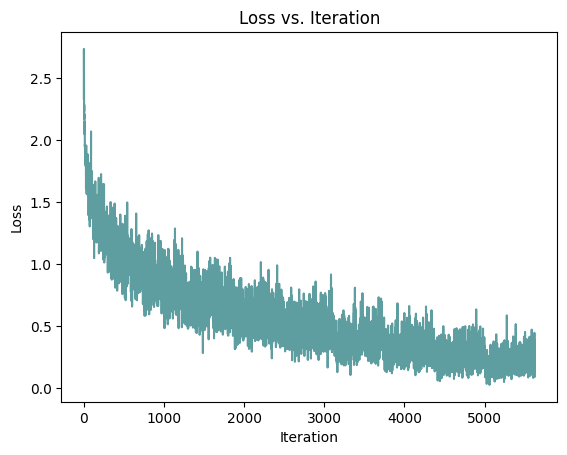

Accuracy: 0.7867, F1-score: 0.7839


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score


data = load_dataset("uoft-cs/cifar10") #loading CIFAR-10 dataset

#defining required transofrmations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#making a custom data "wrapper"
class CustomData(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)                                        #return length of dataset

    def __getitem__(self, idx):
        img = self.dataset[idx]["img"]                                  #get random image
        label = self.dataset[idx]["label"]                              #get corresponding label
        if self.transform:
            img = self.transform(img)                                   #if any transformations applied to self, apply them to our image
        return img, label


#apply transformations to our dataset for workflow in pytorch
full_train_data = CustomData(data["train"], transform=transform)               #full training data
test_data = CustomData(data["test"], transform=transform)                      #full test data

#splitting full training data into training and validation 
train_size = int(0.8 * len(full_train_data))                                   #split full training to 80% training
val_size = len(full_train_data) - train_size                                   #rest is 20% validation data
train_data, val_data = random_split(full_train_data, [train_size, val_size])   #randomly split full training into training and validation

#creating dataloaders for our data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)             #data loader of training set
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)                #data loader of validation set
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)              #data loader of test set

#now, let's define the CNN model, i am using 4 convolutional layers (each followed by a batch normalization layer)
#i tried using 6 layers but it was too slow and it may pose a risk of overfitting
#maxpooling to reduce feature map size gradually
#dropout in fully connected layers to avoid overfitting
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #batch 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)                #conv layer 1
        self.bn1 = nn.BatchNorm2d(64)                                          #Norm Layer after conv 1
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)              #conv layer 2
        self.bn2 = nn.BatchNorm2d(128)                                         #norm layer after conv 2
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)             #conv layer 3
        self.bn3 = nn.BatchNorm2d(256)                                         #norm layer after conv 3
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)             #conv layer 4
        self.bn4 = nn.BatchNorm2d(512)                                         #norm layer after conv 4

        self.pool = nn.MaxPool2d(2,2)
                                      

        #fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)                                          #output layer(10 classes)
        
        #dropout and activation
        self.dropout = nn.Dropout(0.4)                                         #overfitting prevention(dropout)
        self.relu = nn.ReLU()                                                  #activation layer

        #now, let us define the flow of our neural network
    def forward(self, x):
        x = self.pool((self.relu(self.bn1(self.conv1(x)))))
        x = self.pool((self.relu(self.bn2(self.conv2(x)))))
        x = self.pool((self.relu(self.bn3(self.conv3(x)))))
        x = self.pool((self.relu(self.bn4(self.conv4(x)))))
        x = torch.flatten(x, start_dim=1)                                      #flatten feature maps to 1d vector
        x = self.dropout(self.relu(self.fc1(x)))                               #fc layer + dropout
        x = self.fc2(x)                                                        #output layer
        return x

#now we will initialize our model, define the cost function and launch the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")          #use gpu if available
model = CNN().to(device)                                                       #move model to selected device

loss_func = nn.CrossEntropyLoss()                                              #creating loss(cost) function
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)       #adam optimizer with regularization added

#i have made a training loop with early stopping

epochs = 15                                                                    #max no. of epochs
loss_values = []                                                               #Store loss per iteration
iteration = 0                                                                  #iteration tracking

best_val_loss = float('inf')                                                   #Tracking best validation loss
patience = 3                                                                   #Stop training if val loss doesn't improve for 3 epochs
patience_counter = 0          

for epoch in range(epochs):
    model.train()                                                              #set model to training mode
    train_loss = 0.0                                                           #tracking total training loss
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)                  #load images and labels to device
        optimizer.zero_grad()                                                  #reset gradient

        outputs = model(images)
        loss = loss_func(outputs, labels)                                      #compute loss
        loss.backward()                                                        #backpropagation
        optimizer.step()                                                       #upadte weights

        loss_values.append(loss.item())                                        #store loss for plotting
        train_loss += loss.item()
        iteration += 1                                                         #update iteration count

    train_loss /= len(train_loader)                                            #average training loss for the epoch


#starting the validation process(this is NOT the evaluation)
    model.eval()                                                               #set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():                                                      #no calculation of gradient here because we're just evaluating
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)              #load validation dataset to device
            outputs = model(images)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)                                               #avg validation loss for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#code for early stopping --> here our early stopping condition will be checked

    if val_loss < best_val_loss:
        best_val_loss = val_loss                                              #update best validation loss
        patience_counter = 0                                                  #reset patience counter if validation loss improves
    else:
        patience_counter += 1                                                 #increment patience if no improvement

    if patience_counter >= patience:
        print("Early stopping triggered! Training stopped.")
        break                                                                 #stop training if no improvement for 'patience' epochs


#plotting loss vs iteration graph
plt.plot(range(1, len(loss_values) + 1), loss_values, color='cadetblue')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs. Iteration")
plt.show()

#finally, lets evaluate the model

model.eval()                                                                 #setting model to evaluation mode
preds, true_labels = [], []                                                  #store predictions and corresponding true labels

with torch.no_grad():                                                        #turn off gradient
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)                #load test images to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)                                 #get class with highest probability
        preds.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='macro')

print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")                            #print accuracy and f1 score